# Filtrage collaboratif avec Surprise (Simple Python Recommendation System Engine)

## Données

## Chargement du dataframe global

In [1]:
import pandas as pd

df = pd.read_parquet("./data/df_final.parquet")
print("✅ Dataset rechargé avec succès.")

✅ Dataset rechargé avec succès.


In [2]:
df.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,31,32,33,34,35,36,37,38,39,40
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,...,-0.321467,0.910171,0.413014,-0.680843,-0.418416,0.526436,0.305626,-0.30779,-0.606359,-0.650552
1,20,1506825727279757,1506825727000,2,157541,1506836548634,4,1,17,1,...,-0.321467,0.910171,0.413014,-0.680843,-0.418416,0.526436,0.305626,-0.30779,-0.606359,-0.650552
2,44,1506826139185781,1506826139000,5,157541,1506857278141,4,1,17,1,...,-0.321467,0.910171,0.413014,-0.680843,-0.418416,0.526436,0.305626,-0.30779,-0.606359,-0.650552
3,45,1506826142324782,1506826142000,2,157541,1506827309970,4,1,17,1,...,-0.321467,0.910171,0.413014,-0.680843,-0.418416,0.526436,0.305626,-0.30779,-0.606359,-0.650552
4,76,1506826463226813,1506826463000,2,157541,1506828823469,4,3,2,1,...,-0.321467,0.910171,0.413014,-0.680843,-0.418416,0.526436,0.305626,-0.30779,-0.606359,-0.650552


## Chargement des embeddings réduits

In [3]:
import pandas as pd

embeddings_df = pd.read_parquet('./data/articles_embeddings_pca.parquet')
print(embeddings_df.shape)

(364047, 41)


In [4]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
article_id,,,,,,,,,,,,,,,,,,,,,
0,-1.854507,5.592460,1.708684,3.835145,-1.415790,0.252193,0.426064,0.545486,-0.807385,-1.520176,...,0.387722,-0.088794,-0.990522,-1.060112,-0.218404,1.099821,-1.175613,1.370616,-0.264820,0.010121
1,-5.362106,-4.123023,-2.357526,3.428027,0.431052,3.722278,2.389840,-1.267174,1.944113,-2.980639,...,0.025550,-0.721554,-0.649877,0.405266,-0.090767,3.094971,0.075174,0.245277,-1.250361,0.294544
2,-3.600062,0.132090,-6.027454,-0.985620,-0.211971,4.591737,-1.815747,-2.170382,-2.783125,-2.804914,...,0.565644,-1.862216,0.336443,-0.072439,0.241451,0.877662,0.154819,1.133954,0.946722,-1.811296
3,-1.158994,-7.293339,-5.916719,1.370538,-2.172245,-1.682458,1.070833,-2.160003,1.947283,-4.069631,...,0.074059,-0.612829,1.511416,-1.071737,1.991804,2.076192,-1.690456,-1.122755,0.714649,-1.576246
4,-1.143028,-2.569431,-2.891985,0.273959,-2.912984,5.608954,0.308916,0.310898,-1.054211,-2.158129,...,-1.527878,-0.155613,0.163369,-0.037283,1.173571,4.232932,-1.287569,1.053415,-0.486084,-0.144514


## Echantilonnage

In [5]:
def create_subset(df, n_users=None, n_articles=None, n_interactions=None, seed=42, filter_sparse=True):
    """
    Crée un sous-échantillon du DataFrame d'interactions avec un filtrage
    optionnel par nombre d'utilisateurs, d'articles, de lignes, et supprime
    les utilisateurs/articles sans interaction positive si filter_sparse=True.

    Args:
        df (DataFrame): DataFrame principal (doit contenir 'user_id' et 'click_article_id')
        n_users (int, optional): nombre d'utilisateurs à conserver
        n_articles (int, optional): nombre d'articles les plus populaires à conserver
        n_interactions (int, optional): nombre total de lignes à conserver (après filtrage users/articles)
        seed (int): graine pour échantillonnage aléatoire
        filter_sparse (bool): si True, supprime les users/items sans interactions positives

    Returns:
        df_subset (DataFrame): le DataFrame filtré
    """
    df_subset = df.copy()

    if n_users is not None:
        selected_users = df_subset['user_id'].drop_duplicates().sample(n_users, random_state=seed)
        df_subset = df_subset[df_subset['user_id'].isin(selected_users)]

    if n_articles is not None:
        top_articles = df_subset['click_article_id'].value_counts().head(n_articles).index
        df_subset = df_subset[df_subset['click_article_id'].isin(top_articles)]

    if n_interactions is not None and len(df_subset) > n_interactions:
        df_subset = df_subset.sample(n_interactions, random_state=seed)

    # 🧽 Nettoyage des utilisateurs/articles sans rating positif
    if filter_sparse:
        if 'rating' in df_subset.columns:
            pos = df_subset[df_subset['rating'] > 0]
            valid_users = pos['user_id'].unique()
            valid_items = pos['article_id'].unique()
            df_subset = df_subset[
                df_subset['user_id'].isin(valid_users) &
                df_subset['article_id'].isin(valid_items)
            ]

    return df_subset

## Meilleure approche "data"

### Préparation des données pour Surprise

In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from collections import defaultdict
import random
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors

### === 1. Préparation des données === ###

def build_binary_df(df):
    df_binary = df[['user_id', 'click_article_id']].drop_duplicates() # on ne garde qu'une seul interaction user, article
    df_binary['rating'] = 1
    df_binary.columns = ['user_id', 'article_id', 'rating']
    return df_binary


def build_binary_negative_sampling_full(df, min_article_clicks=1):
    # Articles populaires cliqués au moins X fois
    clicked_counts = df['click_article_id'].value_counts()
    clicked_articles = set(clicked_counts[clicked_counts >= min_article_clicks].index)

    df_pos = df[['user_id', 'click_article_id']].drop_duplicates()
    df_pos['rating'] = 1
    df_pos.columns = ['user_id', 'article_id', 'rating']

    user_clicks = df_pos.groupby('user_id')['article_id'].apply(set).to_dict()

    negatives = []

    for user, clicked in user_clicks.items():
        negatives_for_user = clicked_articles - clicked
        for neg_item in negatives_for_user:
            negatives.append((user, neg_item, 0))

    df_neg = pd.DataFrame(negatives, columns=['user_id', 'article_id', 'rating'])
    df_final = pd.concat([df_pos, df_neg], ignore_index=True)
    return df_final


def build_weighted_df(df):
    ''' On prend en compte les clics multiples d'un utilisation sur un même article
        Ils sont agrégés pour produire un score
    '''
    
    df_weighted = (
        df.groupby(['user_id', 'click_article_id'])
          .size()
          .reset_index(name='click_count')
    )
    max_clicks = df_weighted['click_count'].max()
    df_weighted['rating'] = df_weighted['click_count'] / max_clicks
    df_weighted.columns = ['user_id', 'article_id', 'click_count', 'rating']
    return df_weighted[['user_id', 'article_id', 'rating']]


def build_weighted_negative_sampling_full(df, min_article_clicks=1):
    # Articles populaires
    clicked_counts = df['click_article_id'].value_counts()
    clicked_articles = set(clicked_counts[clicked_counts >= min_article_clicks].index)

    df_pos = (
        df.groupby(['user_id', 'click_article_id'])
          .size()
          .reset_index(name='click_count')
    )
    max_clicks = df_pos['click_count'].max()
    df_pos['rating'] = df_pos['click_count'] / max_clicks
    df_pos.columns = ['user_id', 'article_id', 'click_count', 'rating']
    df_pos = df_pos[['user_id', 'article_id', 'rating']]

    user_clicks = df_pos.groupby('user_id')['article_id'].apply(set).to_dict()

    negatives = []

    for user, clicked in user_clicks.items():
        negatives_for_user = clicked_articles - clicked
        for neg_item in negatives_for_user:
            negatives.append((user, neg_item, 0))

    df_neg = pd.DataFrame(negatives, columns=['user_id', 'article_id', 'rating'])
    df_final = pd.concat([df_pos, df_neg], ignore_index=True)
    return df_final


def build_negative_sampling_df(df_pos, embeddings_df, k=10):
    from sklearn.neighbors import NearestNeighbors
    from tqdm.notebook import tqdm

    df_pos_unique = df_pos[['user_id', 'click_article_id']].drop_duplicates()

    model_knn = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric='cosine')
    model_knn.fit(embeddings_df.values)
    article_ids = embeddings_df.index.values
    article_index = {aid: idx for idx, aid in enumerate(article_ids)}

    negatives = []

    user_clicks = df_pos_unique.groupby('user_id')['click_article_id'].apply(set).to_dict()

    print("🔍 Génération du sampling négatif avec embeddings (par utilisateur)...")
    for user, clicked_set in tqdm(user_clicks.items()):
        for pos_item in clicked_set:
            if pos_item not in article_index:
                continue
            idx = article_index[pos_item]
            distances, indices = model_knn.kneighbors([embeddings_df.loc[pos_item].values], n_neighbors=k+1)
            similar_items = [article_ids[i] for i in indices[0][1:] if article_ids[i] not in clicked_set]
            for neg_item in similar_items:
                negatives.append((user, neg_item, 0))

    df_neg = pd.DataFrame(negatives, columns=['user_id', 'article_id', 'rating'])
    df_pos_renamed = df_pos_unique.copy()
    df_pos_renamed.columns = ['user_id', 'article_id']
    df_pos_renamed['rating'] = 1
    df_final = pd.concat([df_pos_renamed, df_neg], ignore_index=True)
    return df_final

### Fonctions d'entrainement de recommandation et mesure de la performance

In [7]:
from surprise import accuracy
### === 2. Pipeline de modélisation et de recommandation === ###

def train_and_evaluate(df_ratings, n_top=5):
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(df_ratings[['user_id', 'article_id', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.2)
    algo = SVD() # choix de l'algorithme (le plus commun)
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Métriques de prédiction
    rmse = accuracy.rmse(predictions, verbose=False)
    mae = accuracy.mae(predictions, verbose=False)

    # Métriques top-N
    top_n = get_top_n(predictions, n=n_top)
    topn_metrics = eval_top_n(top_n, testset, k=n_top)

    return {
        "RMSE": rmse,
        "MAE": mae,
        **topn_metrics
    }
    
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def eval_top_n(top_n, testset, k=5):
    relevance = defaultdict(set)
    for uid, iid, true_r in testset:
        if true_r > 0:
            relevance[uid].add(iid)

    hits, total, ap_sum, ndcg_sum, recall_sum = 0, 0, 0, 0, 0

    for uid, pred_items in top_n.items():
        pred_list = [iid for iid, _ in pred_items]
        true_set = relevance.get(uid, set())
        rel_list = [1 if iid in true_set else 0 for iid in pred_list]

        # HitRate@k
        if any(rel_list):
            hits += 1

        # MAP@k
        if true_set:
            num_hits = 0
            ap = 0
            for i, rel in enumerate(rel_list):
                if rel:
                    num_hits += 1
                    ap += num_hits / (i + 1)
            ap_sum += ap / min(len(true_set), k)

        # NDCG@k
        dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(rel_list))
        ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(len(true_set), k)))
        ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
        ndcg_sum += ndcg

        # Recall@k
        recall = sum(rel_list) / len(true_set) if true_set else 0
        recall_sum += recall

        total += 1

    return {
        "HitRate@5": hits / total,
        "MAP@5": ap_sum / total,
        "NDCG@5": ndcg_sum / total,
        "Recall@5": recall_sum / total
    }

### Expérimentation des différentes approches

In [8]:
import matplotlib.pyplot as plt
### === 3. Expérimentation === ###

def run_comparison(df, embeddings_df=None, df_negatif_precomputed=None):
    results = {}

    print("▶ Approche 1 : score binaire")
    df_binary = build_binary_df(df)
    metrics_binary = train_and_evaluate(df_binary)
    results["binaire"] = metrics_binary

    print("\n▶ Approche 2 : pseudo-rating pondéré")
    df_weighted = build_weighted_df(df)
    metrics_weighted = train_and_evaluate(df_weighted)
    results["pondéré"] = metrics_weighted

    print("\n▶ Approche 3 : sampling négatif avec embeddings")
    if df_negatif_precomputed is not None:
        df_neg = df_negatif_precomputed
    else:
        df_neg = build_negative_sampling_df(df, embeddings_df, k=10)
    results["négatif_embedding"] = train_and_evaluate(df_neg)

    print("\n▶ Approche 4 : binaire + full négatifs")
    df_bin_full = build_binary_negative_sampling_full(df)
    results["binaire + full neg"] = train_and_evaluate(df_bin_full)

    print("\n▶ Approche 5 : pondéré + full négatifs")
    df_weight_full = build_weighted_negative_sampling_full(df)
    results["pondéré + full neg"] = train_and_evaluate(df_weight_full)
    
    # Convertir en DataFrame pour affichage
    df_results = pd.DataFrame(results).T
    print("\n🎯 Résumé des performances (k=5) :")
    print(df_results)

    # Séparer les métriques pour double échelle
    topn_metrics = ["HitRate@5", "MAP@5", "NDCG@5", "Recall@5"]
    error_metrics = ["RMSE", "MAE"]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Barres des top-N metrics (gauche)
    df_results[topn_metrics].plot(kind='bar', ax=ax1, position=0, width=0.4, colormap='tab10')
    ax1.set_ylabel("Top-N Metrics")
    ax1.set_ylim(0, 1.05)
    ax1.set_xlabel("Approche")
    ax1.set_xticklabels(df_results.index, rotation=0)
    ax1.legend(loc='upper left')

    # Barres des error metrics (droite)
    ax2 = ax1.twinx()
    df_results[error_metrics].plot(kind='bar', ax=ax2, position=1, width=0.4, color=["gray", "black"])
    ax2.set_ylabel("Erreur (RMSE / MAE)")
    ax2.legend(loc='upper right')

    plt.title("Comparaison des approches - Surprise (k=5)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

🔍 Génération du sampling négatif avec embeddings (par utilisateur)...


  0%|          | 0/1000 [00:00<?, ?it/s]

▶ Approche 1 : score binaire

▶ Approche 2 : pseudo-rating pondéré

▶ Approche 3 : sampling négatif avec embeddings

▶ Approche 4 : binaire + full négatifs

▶ Approche 5 : pondéré + full négatifs

🎯 Résumé des performances (k=5) :
                        RMSE       MAE  HitRate@5     MAP@5    NDCG@5  \
binaire             0.058431  0.030104   1.000000  1.000000  1.000000   
pondéré             0.090032  0.064897   1.000000  1.000000  1.000000   
négatif_embedding   0.339192  0.259319   0.843583  0.812556  0.823158   
binaire + full neg  0.061132  0.008614   0.202000  0.062976  0.088835   
pondéré + full neg  0.021102  0.002932   0.215000  0.067554  0.094684   

                    Recall@5  
binaire             0.963126  
pondéré             0.961564  
négatif_embedding   0.803135  
binaire + full neg  0.105743  
pondéré + full neg  0.113139  


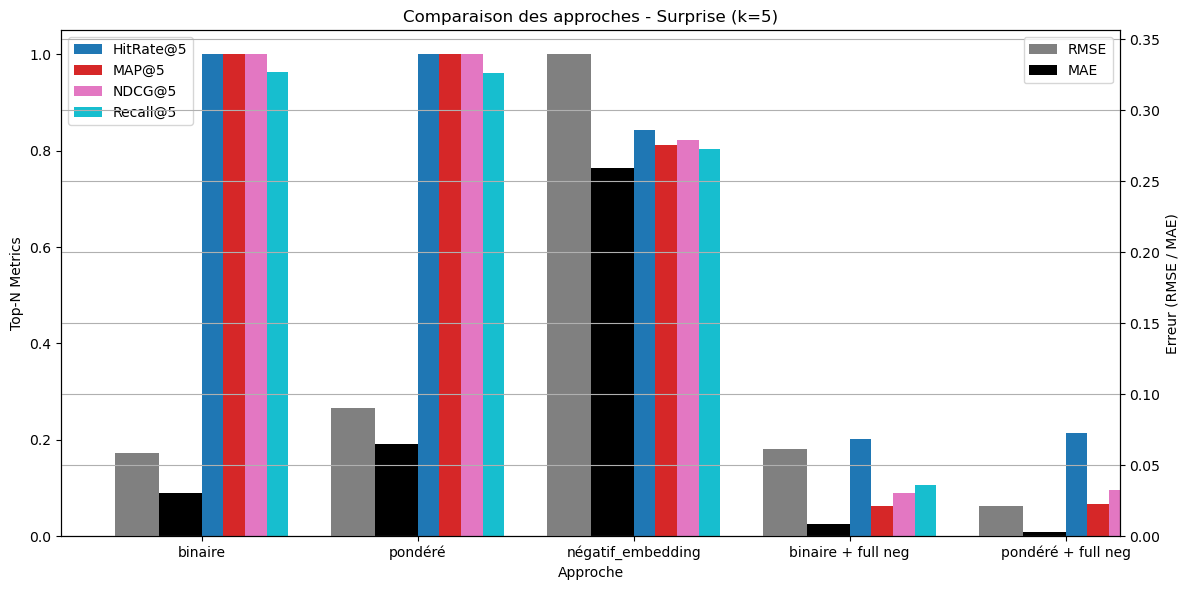

In [9]:
df_small = create_subset(df, n_users=1000, n_articles=3000, n_interactions=100_000)
df_negatif_embedding = build_negative_sampling_df(df_small, embeddings_df, k=10)
df_negatif_embedding = create_subset(df_negatif_embedding, filter_sparse=True)
results_df = run_comparison(df_small, df_negatif_precomputed=df_negatif_embedding)

🧠 Conclusion sur le choix de l'approche :

    ✔️ Ajouter des négatifs ciblés (via embeddings) permet au modèle de mieux généraliser.
    ❌ Travailler uniquement avec des clics ou ajouter tous les non-clics (full) fausse l’apprentissage.
    🔎 Les métriques classiques comme RMSE/MAE ne suffisent pas à évaluer un système de recommandation implicite.

## Tests de différents algorithmes

In [10]:
from surprise import Dataset, Reader, SVD, SVDpp, NMF, KNNBasic, BaselineOnly, CoClustering
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict
import pandas as pd
import numpy as np


### Fonction d'évaluation des recommandations

In [11]:
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def eval_top_n(top_n, testset, k=5):
    relevance = defaultdict(set)
    for uid, iid, true_r in testset:
        if true_r > 0:
            relevance[uid].add(iid)

    hits, total, ap_sum, ndcg_sum, recall_sum = 0, 0, 0, 0, 0

    for uid, pred_items in top_n.items():
        pred_list = [iid for iid, _ in pred_items]
        true_set = relevance.get(uid, set())
        rel_list = [1 if iid in true_set else 0 for iid in pred_list]

        if any(rel_list):
            hits += 1

        if true_set:
            num_hits = 0
            ap = 0
            for i, rel in enumerate(rel_list):
                if rel:
                    num_hits += 1
                    ap += num_hits / (i + 1)
            ap_sum += ap / min(len(true_set), k)

        dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(rel_list))
        ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(len(true_set), k)))
        ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
        ndcg_sum += ndcg

        recall = sum(rel_list) / len(true_set) if true_set else 0
        recall_sum += recall

        total += 1

    return {
        "HitRate@5": hits / total,
        "MAP@5": ap_sum / total,
        "NDCG@5": ndcg_sum / total,
        "Recall@5": recall_sum / total
    }


### Fonction de comparaison des algorithmes

In [12]:
from surprise import AlgoBase
import random

class RandomPredictor(AlgoBase):
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        return self

    def estimate(self, u, i):
        return random.uniform(0, 1)


<i> Pour knn il n'est pas possible de calculer la matrice de similarité complète, on teste item-item et user-user sur des échantillons d'où l'option sim 

In [13]:
def compare_algos(df_ratings, k=5):
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(df_ratings[['user_id', 'article_id', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.2)

    algos = {
    "SVD": SVD(),
    "SVDpp": SVDpp(),
    "NMF": NMF(),
    "KNN_user": KNNBasic(
        k=40,
        sim_options={
            'name': 'msd', # malgré le filtre pour éviter les users sans interaction cosine génère une div.0 Mean Squared Difference
            'user_based': True
        }
    ),
    "KNN_item": KNNBasic(
        k=40,
        sim_options={
            'name': 'msd', #
            'user_based': False
        }
    ),
    "BaselineOnly": BaselineOnly(),
    "CoClustering": CoClustering(),
    "Random": RandomPredictor()
    }

    results = {}
    for name, algo in algos.items():
        print(f"\n▶ Entraînement de {name}...")
        algo.fit(trainset)
        predictions = algo.test(testset)
        rmse = accuracy.rmse(predictions, verbose=False)
        mae = accuracy.mae(predictions, verbose=False)
        top_n = get_top_n(predictions, n=k)
        metrics = eval_top_n(top_n, testset, k=k)
        results[name] = {"RMSE": rmse, "MAE": mae, **metrics}

    return pd.DataFrame(results).T


In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_algo_comparison(df_results):
    topn_metrics = ["HitRate@5", "MAP@5", "NDCG@5", "Recall@5"]
    error_metrics = ["RMSE", "MAE"]

    n_algos = len(df_results)
    n_topn = len(topn_metrics)
    n_errors = len(error_metrics)

    index = np.arange(n_algos)
    bar_width = 0.12

    # Palette douce de bleus
    blue_palette = ["#a6cee3", "#1f78b4", "#6baed6", "#3182bd"]

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Barres Top-N
    for i, metric in enumerate(topn_metrics):
        ax1.bar(index + i * bar_width - (n_topn / 2) * bar_width,
                df_results[metric], width=bar_width,
                label=metric, color=blue_palette[i])

    ax1.set_ylabel("Top-N Metrics")
    ax1.set_ylim(0, 1.05)
    ax1.set_xlabel("Algorithme")
    ax1.set_xticks(index)
    ax1.set_xticklabels(df_results.index, rotation=0)
    ax1.legend(loc='upper left')

    # Barres d'erreur sur axe secondaire
    ax2 = ax1.twinx()
    ax2.bar(index + (n_topn) * bar_width - (n_topn / 2) * bar_width,
            df_results["RMSE"], width=bar_width, color="dimgray", label="RMSE")
    ax2.bar(index + (n_topn + 1) * bar_width - (n_topn / 2) * bar_width,
            df_results["MAE"], width=bar_width, color="black", label="MAE")

    ax2.set_ylabel("Erreur (RMSE / MAE)")
    ax2.legend(loc='lower right')

    plt.title("Comparaison des algorithmes Surprise (k=5)")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


### Comparaison et visualisation des résultats avec différents algorithmes

In [15]:
algo_comparison = compare_algos(df_negatif_embedding, k=5)


▶ Entraînement de SVD...

▶ Entraînement de SVDpp...

▶ Entraînement de NMF...

▶ Entraînement de KNN_user...
Computing the msd similarity matrix...
Done computing similarity matrix.

▶ Entraînement de KNN_item...
Computing the msd similarity matrix...
Done computing similarity matrix.

▶ Entraînement de BaselineOnly...
Estimating biases using als...

▶ Entraînement de CoClustering...

▶ Entraînement de Random...


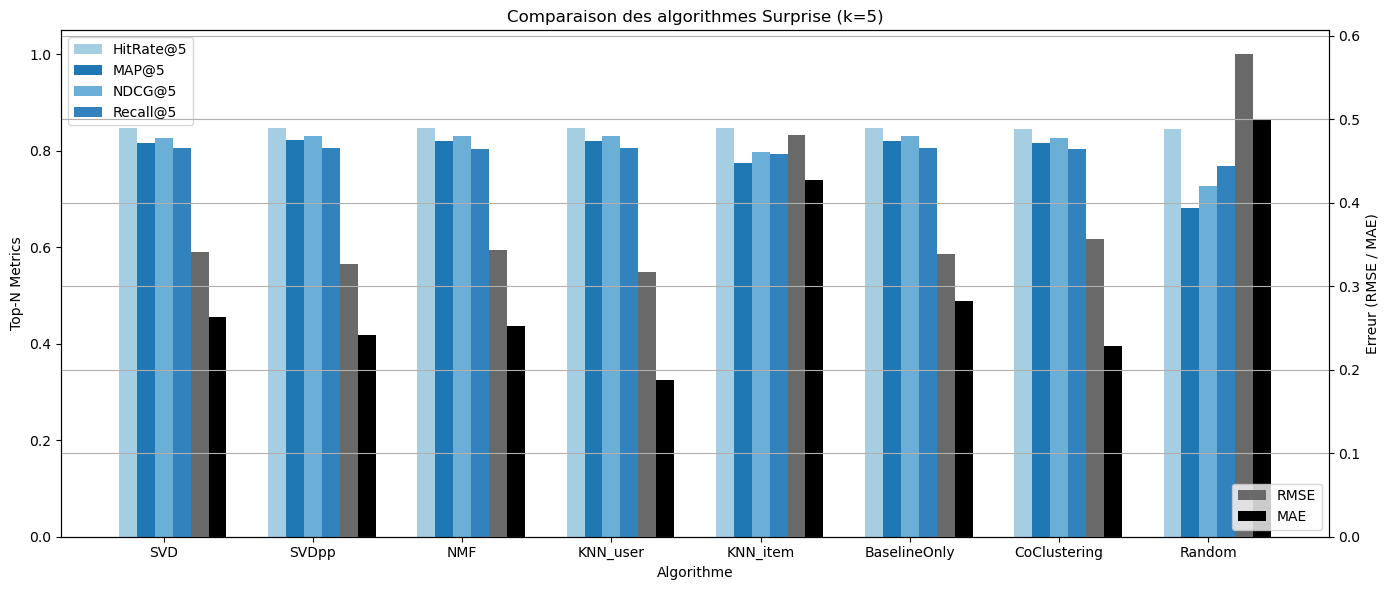

In [29]:
plot_algo_comparison(algo_comparison)

## Optimisation du meilleur algorithme

🔍 On va optimiser par GridSearch sur KNN_user avec Surprise

On va faire varier :

- k : nombre de voisins (taille du voisinage)
- min_k : minimum de voisins requis pour prédire
- similarity : type de similarité <br>
Il faut filter la matrice des embeddings négatifs pour exclure les users avec un rating de 0 (erreur de div 0 pour cosine et pearson), mais pas depuis la matrice sparse

In [53]:
# 1. Créer un subset
df_test = create_subset(df, n_users=1000, n_articles=3000, n_interactions=100_000)

# 2. Sampling négatif
df_negatif_embedding = build_negative_sampling_df(df_test, embeddings_df, k=10)

# 3. 🧠 Nouveau filtrage minimal : ne supprimer que les user/items sans AUCUNE interaction
user_counts = df_negatif_embedding['user_id'].value_counts()
item_counts = df_negatif_embedding['article_id'].value_counts()

df_clean = df_negatif_embedding[
    df_negatif_embedding['user_id'].isin(user_counts[user_counts >= 2].index) &
    df_negatif_embedding['article_id'].isin(item_counts[item_counts >= 2].index)
]

🔍 Génération du sampling négatif avec embeddings (par utilisateur)...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [72]:
print(df_clean['rating'].value_counts())

rating
0    73967
1     7336
Name: count, dtype: int64


In [73]:
def print_dataset_reduction(df_original, df_cleaned, label="dataset"):
    n_users_before = df_original['user_id'].nunique()
    n_items_before = df_original['article_id'].nunique()
    n_inter_before = len(df_original)

    n_users_after = df_cleaned['user_id'].nunique()
    n_items_after = df_cleaned['article_id'].nunique()
    n_inter_after = len(df_cleaned)

    print(f"📊 Réduction sur {label} :")
    print(f" - Utilisateurs : {n_users_before} → {n_users_after} ({100 * n_users_after / n_users_before:.1f}%)")
    print(f" - Articles     : {n_items_before} → {n_items_after} ({100 * n_items_after / n_items_before:.1f}%)")
    print(f" - Interactions : {n_inter_before:,} → {n_inter_after:,} ({100 * n_inter_after / n_inter_before:.1f}%)")

# Utilisation :
print_dataset_reduction(df_negatif_embedding, df_clean, label="sampling négatif (embedding)")


📊 Réduction sur sampling négatif (embedding) :
 - Utilisateurs : 1000 → 995 (99.5%)
 - Articles     : 20024 → 9442 (47.2%)
 - Interactions : 91,885 → 81,303 (88.5%)


In [74]:
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV
from surprise import Dataset, Reader

# Grille de paramètres
param_grid = {
    'k': [20, 40, 60],
    'min_k': [1, 3, 5],
    'sim_options__name': ['cosine', 'msd', 'pearson'],
    'sim_options__user_based': [True]  # ou False pour item-based
}

In [75]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(df_clean[['user_id', 'article_id', 'rating']], reader)

In [76]:
gs = GridSearchCV(
    algo_class=KNNBasic,
    param_grid=param_grid,
    measures=['rmse', 'mae'],
    cv=3,
    n_jobs=-1,
    joblib_verbose=1
)
gs.fit(data)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    6.2s finished


🏆 Meilleurs paramètres

In [77]:
print("Best RMSE score:", gs.best_score['rmse'])
print("Best parameters:", gs.best_params['rmse'])

Best RMSE score: 0.13007911310687814
Best parameters: {'k': 20, 'min_k': 1, 'sim_options__name': 'cosine', 'sim_options__user_based': True}


📊 Classement des meilleurs modèles

In [78]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df = results_df.sort_values(by='mean_test_rmse')
display(results_df[['params', 'mean_test_rmse', 'mean_test_mae']])

,params,mean_test_rmse,mean_test_mae
0,"{'k': 20, 'min_k': 1, 'sim_options__name': 'co...",0.130079,0.029606
1,"{'k': 20, 'min_k': 1, 'sim_options__name': 'ms...",0.130079,0.029606
2,"{'k': 20, 'min_k': 1, 'sim_options__name': 'pe...",0.130079,0.029606
9,"{'k': 40, 'min_k': 1, 'sim_options__name': 'co...",0.130554,0.030144
10,"{'k': 40, 'min_k': 1, 'sim_options__name': 'ms...",0.130554,0.030144
11,"{'k': 40, 'min_k': 1, 'sim_options__name': 'pe...",0.130554,0.030144
20,"{'k': 60, 'min_k': 1, 'sim_options__name': 'pe...",0.130859,0.030422
19,"{'k': 60, 'min_k': 1, 'sim_options__name': 'ms...",0.130859,0.030422
18,"{'k': 60, 'min_k': 1, 'sim_options__name': 'co...",0.130859,0.030422
3,"{'k': 20, 'min_k': 3, 'sim_options__name': 'co...",0.158838,0.049491


In [81]:
# ⚙️ Reconstruction du trainset complet
trainset = data.build_full_trainset()

# 🏆 Extraction du meilleur algo trouvé par GridSearch
best_algo = gs.best_estimator['mae']
best_params = gs.best_params['mae']
best_algo.fit(trainset)

# 🔍 Affichage clair des hyperparamètres
print("🔧 Paramètres du meilleur modèle :")
print(f" - k              : {best_params['k']}")
print(f" - min_k          : {best_params['min_k']}")
print(f" - similarité     : {best_params['sim_options__name']}")
print(f" - user_based     : {best_params['sim_options__user_based']}")

# 📌 Générer le testset manuellement (tous les ratings connus)
testset = trainset.build_testset()
predictions = best_algo.test(testset)

# 🔢 Métriques de prédiction
from surprise import accuracy
rmse = accuracy.rmse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)

# 🔝 Métriques de recommandation top-N
top_n = get_top_n(predictions, n=5)
topn_metrics = eval_top_n(top_n, testset, k=5)

# 🧾 Résumé
print("\n🎯 Résultats finaux sur le meilleur modèle (top-5) :")
print(f"RMSE       : {rmse:.4f}")
print(f"MAE        : {mae:.4f}")
for k, v in topn_metrics.items():
    print(f"{k:<12}: {v:.4f}")


Computing the msd similarity matrix...
Done computing similarity matrix.
🔧 Paramètres du meilleur modèle :
 - k              : 20
 - min_k          : 1
 - similarité     : cosine
 - user_based     : True

🎯 Résultats finaux sur le meilleur modèle (top-5) :
RMSE       : 0.0826
MAE        : 0.0140
HitRate@5   : 0.9779
MAP@5       : 0.9660
NDCG@5      : 0.9708
Recall@5    : 0.7714


In [86]:
from termcolor import colored
import random

def show_topn_with_truth(top_n, df_truth, n_users=5):
    """
    Affiche les top-N recommandations + les articles cliqués,
    en rouge les articles qui sont à la fois recommandés et cliqués.

    Args:
        top_n (dict): top-N recommandations {user_id: [(article_id, score), ...]}
        df_truth (DataFrame): interactions positives avec colonnes user_id, article_id, rating
        n_users (int): nombre d’utilisateurs à afficher
    """
    sampled_users = random.sample(list(top_n.keys()), n_users)

    for uid in sampled_users:
        print(f"\n👤 Utilisateur {uid} :")
        
        # Top-N recommandations
        print("🔝 Recommandations top-5 :")
        recs = [iid for iid, _ in top_n[uid]]
        for rank, (iid, score) in enumerate(top_n[uid], 1):
            print(f"  {rank}. Article {iid} — score estimé : {score:.4f}")

        # Articles cliqués
        real_clicks = df_truth[
            (df_truth['user_id'] == uid) & 
            (df_truth['rating'] > 0)
        ]['article_id'].unique()
        
        print("✅ Articles réellement cliqués :")
        if len(real_clicks):
            for aid in real_clicks:
                label = colored(str(aid), 'red') if aid in recs else str(aid)
                print(f"  - {label}")
        else:
            print("  (aucun)")


In [88]:
# df_clean contient les vraies interactions utilisateur-article avec rating binaire
show_topn_with_truth(top_n, df_clean, n_users=5)


👤 Utilisateur 64042 :
🔝 Recommandations top-5 :
  1. Article 284666 — score estimé : 0.8571
  2. Article 303846 — score estimé : 0.5556
  3. Article 285939 — score estimé : 0.1429
  4. Article 304641 — score estimé : 0.0000
  5. Article 303739 — score estimé : 0.0000
✅ Articles réellement cliqués :
  - 284666
  - 303846

👤 Utilisateur 120714 :
🔝 Recommandations top-5 :
  1. Article 198659 — score estimé : 1.0000
  2. Article 272143 — score estimé : 1.0000
  3. Article 64329 — score estimé : 1.0000
  4. Article 348111 — score estimé : 1.0000
  5. Article 124749 — score estimé : 1.0000
✅ Articles réellement cliqués :
  - 198659
  - 272143
  - 64329
  - 348111
  - 124749
  - 97082
  - 20691
  - 96210
  - 288440

👤 Utilisateur 143495 :
🔝 Recommandations top-5 :
  1. Article 187065 — score estimé : 1.0000
  2. Article 313431 — score estimé : 1.0000
  3. Article 30576 — score estimé : 0.5000
  4. Article 30771 — score estimé : 0.5000
  5. Article 31001 — score estimé : 0.0000
✅ Articles rée

## Généralisation par une fonction